# SMART
This file loads the trained category and type classifiers. Then predicts and evaluates the results.

In [1]:
import utils
import pickle
import numpy as np
import gensim 
import json
import matplotlib.pyplot as plt
from evaluation.dbpedia import evaluate # evaluation script
from gensim.models import Word2Vec 
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords 
from elasticsearch import Elasticsearch

## Classify the category

In [2]:
clf_category_baseline = pickle.load(open('category_classifier_baseline.sav', 'rb'))
clf_category_adv = pickle.load(open('category_classifier_advanced.sav', 'rb'))

In [3]:
test = utils.load_dataset('datasets/DBpedia/test_grnd.json')

In [4]:
_, _, X_test, y_test = utils.prepare_X_y({}, test)
test_vectors = utils.transform_dataset(X_test, 'category_vectorizer.sav')

In [5]:
pred_category_baseline = clf_category_baseline.predict(test_vectors)
print("Baseline accuracy:", sum(pred_category_baseline==y_test)/len(pred_category_baseline))

pred_category_adv = clf_category_adv.predict(test_vectors)
print("Advanced accuracy:", sum(pred_category_adv==y_test)/len(pred_category_adv))

Baseline accuracy: 0.9226380648105887
Advanced accuracy: 0.9415791875855773


In [6]:
nBool = 0
nBoolWrong = 0
nBoolWrong_b = 0
nLiteral = 0
nLiteralWrong = 0
nLiteralWrong_b = 0
nResource = 0
nResourceWrong = 0
nResourceWrong_b = 0
for i in range(len(pred_category_adv)):
    # baseline
    if pred_category_baseline[i] != y_test[i]:
        if y_test[i] == "boolean":
             nBoolWrong_b += 1
        elif y_test[i] == "literal":
            nLiteralWrong_b += 1
        elif y_test[i] == "resource":
            nResourceWrong_b += 1
    
    # advanded
    if pred_category_adv[i] != y_test[i]:
        if y_test[i] == "boolean":
             nBoolWrong += 1
        elif y_test[i] == "literal":
            nLiteralWrong += 1
        elif y_test[i] == "resource":
            nResourceWrong += 1
            
    # ground truth
    if y_test[i] == "boolean":
         nBool += 1
    elif y_test[i] == "literal":
         nLiteral += 1
    elif y_test[i] == "resource":
        nResource += 1

In [7]:
nCategories = [nBool, nLiteral, nResource]
nWrong = [nBoolWrong, nLiteralWrong, nResourceWrong]
nWrong_b = [nBoolWrong_b, nLiteralWrong_b, nResourceWrong_b]
nProp = [x/y for x, y in zip(nWrong, nCategories)]
nProp_b = [x/y for x, y in zip(nWrong_b, nCategories)]

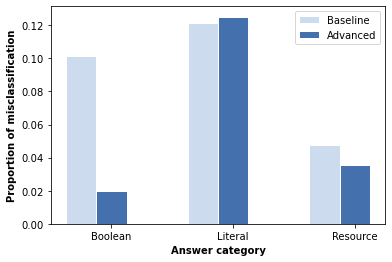

In [8]:
barWidth = 0.25 

# set height of bar
bars_a = nProp
bars_b = nProp_b

# Set position of bar on X axis
r1 = np.arange(len(bars_b))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, bars_b, color="#ccdbee", width=barWidth, edgecolor="white", label="Baseline")
plt.bar(r2, bars_a, color="#4470ad", width=barWidth, edgecolor="white", label="Advanced")

# Add xticks on the middle of the group bars
plt.xticks([r + barWidth for r in range(len(bars_b))], ['Boolean', 'Literal', 'Resource'])

# Label and show the bars
plt.xlabel('Answer category', fontweight='bold')
plt.ylabel('Proportion of misclassification', fontweight='bold')
plt.legend()
plt.show()

## Classify the type

In [9]:
clf_type_literal = pickle.load(open('type_literal_classifier.sav', 'rb'))

In [10]:
def split_bool_literal_reference(X, y):
    bool_map = {}
    literal_map = {}
    resource_map = {}

    for i in range(len(y)):
        if y[i] == 'boolean':
            bool_map[i] = X[i]
        elif y[i] == 'literal':
            literal_map[i] = X[i]
        elif y[i] == 'resource':
            resource_map[i] = X[i]
            
    return bool_map, literal_map, resource_map

In [11]:
bool_map, literal_map, resource_map = split_bool_literal_reference(X_test, pred_category_adv)

In [12]:
X_test_literal = list(literal_map.values())
y_test_literal = []
for i in list(literal_map.keys()):
    y_test_literal.append(test[i]['type'][0])

In [13]:
test_vectors_literal = utils.transform_dataset(X_test_literal, 'literal_vectorizer.sav')

In [14]:
pred_literal = clf_type_literal.predict(test_vectors_literal)
print("Accuracy:", sum(pred_literal==y_test_literal)/len(pred_literal))

Accuracy: 0.9133790737564322


## Bundle

In [15]:
es = Elasticsearch()
INDEX_NAME = 'questions'
es.info()

{'name': 'Karl-PC',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'c2RTr28oQWi6_aB1dQbLmA',
 'version': {'number': '7.9.1',
  'build_flavor': 'default',
  'build_type': 'tar',
  'build_hash': '083627f112ba94dffc1232e8b42b73492789ef91',
  'build_date': '2020-09-01T21:22:21.964974Z',
  'build_snapshot': False,
  'lucene_version': '8.6.2',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}

In [16]:
q = 'Is cola healthy?'

es.search(index=INDEX_NAME, q=q, _source=True, size=2).get('hits', {}).get('hits', {})

[{'_index': 'questions',
  '_type': '_doc',
  '_id': 'dbpedia_16642',
  '_score': 9.011995,
  '_source': {'question': 'Who manufactures Coca-Cola?',
   'category': 'resource',
   'type': ['dbo:Company', 'dbo:Organisation', 'dbo:Agent']}},
 {'_index': 'questions',
  '_type': '_doc',
  '_id': 'dbpedia_3697',
  '_score': 7.914068,
  '_source': {'question': 'What products does Coca-Cola produce?',
   'category': 'resource',
   'type': ['dbo:Company', 'dbo:Organisation', 'dbo:Agent']}}]

In [17]:
stop_words = set(stopwords.words('english'))
word2vec_sg = pickle.load(open('word2vec_sg.sav', 'rb'))
word2vec_sg.wv.most_similar('church') # Check if working

[('line', 0.9956303238868713),
 ('Hotel', 0.9916583299636841),
 ('building', 0.990936815738678),
 ('Castle', 0.9899001121520996),
 ('ground', 0.9898924827575684),
 ('RailwayLine', 0.9895331859588623),
 ('Skyscraper', 0.9892098903656006),
 ('hub', 0.9878330826759338),
 ('Dam', 0.9874654412269592),
 ('station', 0.986347496509552)]

In [18]:
def predict_resource_types(es, testdata, index, model, index_name='questions', size=5):
    q = testdata[index]['question']
    q = " ".join([w for w in word_tokenize(q)  if not w in stop_words])
    results = []
    try:
        results = es.search(index=index_name, q=q, _source=True, size=size).get('hits', {}).get('hits', {})
    except:
        return []
    types = set([])
    for result in results:
        for t in result['_source']['type']:
            if len(t.split()) == 1:
                types.add(t)

    q_terms = q.split() # Question terms
    t_terms = list(types) # Types from search
    if 'dbo:Location' in t_terms: # Known invalid ontology
        t_terms.remove('dbo:Location') 
    pred_types = set([])
     
    return predictTypes(model, q_terms, t_terms)

In [19]:
def predictTypes(model, q_terms, t_terms, nTerms=5):
    threshold = 1.0
    pred_types = set([])
    while len(pred_types) < nTerms:
        for i in q_terms:
            for j in t_terms:
                try:
                    score = model.wv.similarity(i, j[4:])
                    if score > threshold:
                        pred_types.add(j)
                except:
                    pass
        threshold -= 0.05
        if threshold < 0.6:
            break
#     if len(pred_types) > 5:
#         return list(pred_types)[0:6]
    pred_types = list(pred_types)
    pred_types.sort()
    return pred_types

In [20]:
predict_resource_types(es, test, 12, word2vec_sg)

['dbo:Asteroid', 'dbo:CelestialBody', 'dbo:Place', 'dbo:Planet']

In [21]:
type_preds = []
count_literal = 0
for i in range(len(test)):
    
    if i in bool_map:
        type_preds.append(['boolean'])
    if i in literal_map:
        type_preds.append([pred_literal[count_literal]])
        count_literal += 1
    if i in resource_map:
        type_preds.append(predict_resource_types(es, test, i, word2vec_sg))

In [22]:
type_preds[0:5]

[['number'],
 ['dbo:Agent',
  'dbo:Company',
  'dbo:MusicalWork',
  'dbo:RecordLabel',
  'dbo:Single',
  'dbo:Work'],
 ['number'],
 ['boolean'],
 ['string']]

In [23]:
predict_resource_types(es, test, 1, word2vec_sg)

['dbo:Agent',
 'dbo:Company',
 'dbo:MusicalWork',
 'dbo:RecordLabel',
 'dbo:Single',
 'dbo:Work']

In [24]:
y_test_types = []
    
for doc in test:
    y_test_types.append(doc['type'])

In [25]:
preds = utils.load_dataset('datasets/DBpedia/test.json')
for i, doc in enumerate(preds):
    
    if i in bool_map:
        doc['category'] = 'boolean'
    if i in literal_map:
        doc['category'] = 'literal'
    if i in resource_map:
        doc['category'] = 'resource'
    doc['type'] = type_preds[i]

with open('datasets/DBpedia/preds_advanced.json', 'w') as file:
    json.dump(preds, file, indent=4)

In [26]:
%run 'evaluation/dbpedia/evaluate.py' 'evaluation/dbpedia/dbpedia_types.tsv' 'datasets/DBpedia/test_grnd.json' 'datasets/DBpedia/preds_advanced.json'

Loading type hierarchy from evaluation/dbpedia/dbpedia_types.tsv... 760 types loaded (max depth: 7)
Loading ground truth from datasets/DBpedia/test_grnd.json... 
   4367 questions loaded
Loading system predictions from datasets/DBpedia/preds_advanced.json... 
   4367 predictions loaded




Evaluation results:
-------------------
Category prediction (based on 4367 questions)
  Accuracy: 0.941
Type ranking (based on 3422 questions)
  NDCG@5:  0.618
  NDCG@10: 0.590


In [27]:
temp = utils.load_dataset('datasets/DBpedia/preds_advanced.json')

# Print average number of answer types
c = 0
n= 0
for doc in temp:
    if doc['category'] == 'resource':
        c += len(doc['type'])
        n += 1
c/n

4.516826923076923

Decisions made:

* We used MLP for category classification because there are a known amount of labels (multi class classification)
* Boolean category is always boolean type, so no need for further classification/ prediction
* We used MLP for literal type classifications because there are a known amount of labels (multi class classification)
* We use CountVectorizer because TFIDF penalize frequent words (who, what ...)
* We use pickle to serialize MLP models and vectorizers
* For resource, we start by looking for similar questions using elasticsearch (bm25)
* Use skip-gram word2vec embedding to cross-reference types found in search and terms in query
* Skip-gram predict the context better than CBOW (CBOW often have meaningless predictions)
* Mention that we ignore types that are more than one word due to limitations in word2vec
* Boolean and literal types have a strict scoring (0 or 1)
* Have not decided how to score resource types (+/- proportion of terms)

TODO:
* Optimize MLP models
* Improve implementation of resource scoring
* Extend the indexed text by concatenating description of the types
* Type hierarchy
* Try dbpedia

* How we concatenate question and types in word2vec have a major impact on performance
